### Anomalies in Time Series Data
#### Lesson Goals
- Use entropy as a quick way to identify fields that may have anomalies.
- Use statistical properties to flag the data points that deviate from the expected.
#### The Data
- Logs of API requests to our data containing sales information about our stores and items.
- Type of target variable: Continuous or Discrete
- Type of observations: Time Series or Point in Time
#### The Questions
- Are there unusual IP addresses accessing our data via the API?
- Have we seen any spikes or unusual patterns in the size of requests?
- In general: Does this new value deviate from what we would expect based on historical data? If so, is it something to be concerned about? Remember, we aren't detecting anomalies for the sake of detecting anomalies.

In [2]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from scipy.stats import entropy
from acquire import get_codeup_data
from prepare import combine_codeup_data
from prepare import null_filler

import math

import warnings
warnings.filterwarnings("ignore")

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

#### Acquiring data

In [3]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df = pd.read_csv('https://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

In [4]:
# narrowing df to only the variables we need
df = df[['ip', 'timestamp', 'size']]

#### Explore IP Address
In this sample data, it's pretty easy to take a look at value counts to see those IP's that are rare. However, usually the data is much, much larger and looking at simple value counts is not going to be enough.

In [5]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [6]:
compute_entropy(df.ip)

0.5648495339393655

#### Prepare Data to Explore Size
First, we will resample the existing data to 30 minute increments.

In [7]:
df.head()

,ip,timestamp,size
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],512495
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],3561
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],510103
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],510003
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],511963


In [8]:
# select timestamp
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))
df = df.set_index('timestamp')
df = df[['size']].resample('1d').sum()

In [9]:
df = df.fillna(value=0)
df.describe()

,size
count,2.000000e+00
mean,3.143457e+09
std,3.305049e+09
min,8.064345e+08
25%,1.974946e+09
50%,3.143457e+09
75%,4.311968e+09
max,5.480479e+09


#### Aside: Simulate some new data to manufacture some anomalies
Now, let's create a new dataframe that extends our data another year or so.

In [10]:
new = pd.DataFrame([["[18/Apr/2019:00:00:00+0000]", 0],
                    ["[15/Mar/2020:00:00:00+0000]", 0]], columns=['timestamp','size'])

In [11]:
# resampling
new.timestamp = new.timestamp.str.replace(r'(\[|\])', '', regex=True)
new.timestamp = pd.to_datetime(new.timestamp.str.replace(':', ' ', 1))
new = new.set_index('timestamp')
new = new.resample('1d').sum()

In [12]:
new = new.fillna(value=0)
new.tail()

,size
timestamp,
2020-03-11 00:00:00+00:00,0
2020-03-12 00:00:00+00:00,0
2020-03-13 00:00:00+00:00,0
2020-03-14 00:00:00+00:00,0
2020-03-15 00:00:00+00:00,0


In [13]:
# get mean and standard deviation for randomly generating some data. 
mean = df['size'].mean()
std = df['size'].std()

Fill values with random number between [0, mean+2*standard deviation].

In [14]:
# new['size'] = new['size'].apply(lambda x: max(np.rint(np.random.normal(mean, std)), 0) if x==0 else x)
new['size'] = new['size'].apply(lambda x: np.random.randint(0, mean+2*std) if x==0 else x)

In [15]:
new.describe()

,size
count,3.330000e+02
mean,4.935476e+09
std,2.749943e+09
min,2.802129e+07
25%,2.594611e+09
50%,4.865712e+09
75%,7.379381e+09
max,9.727083e+09


Fill with some anomalies by replacing the zeros that remain with random number between [(mean+2*std), (mean+5*std)]

In [16]:
new['size'] = new['size'].apply(lambda x: np.random.randint(mean+5*std, mean+9*std) if x<200000000 else x)

In [17]:
new.describe()

,size
count,3.330000e+02
mean,5.357306e+09
std,3.647827e+09
min,2.272702e+08
25%,2.777451e+09
50%,5.014886e+09
75%,7.543982e+09
max,2.698574e+10


Concatentate our new data with our original data

In [18]:
df = pd.concat([df, new])

(array([92., 97., 85., 55.,  0.,  0.,  0.,  1.,  3.,  2.]),
 array([2.27270169e+08, 2.90311764e+09, 5.57896512e+09, 8.25481259e+09,
        1.09306601e+10, 1.36065075e+10, 1.62823550e+10, 1.89582025e+10,
        2.16340500e+10, 2.43098974e+10, 2.69857449e+10]),
 <a list of 10 Patch objects>)

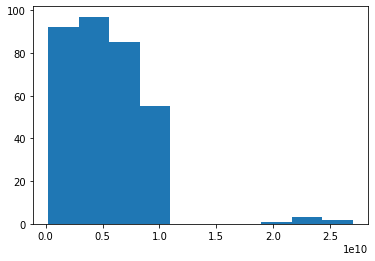

In [19]:
plt.hist(df['size'])

## Explore Size
First, let's represent size in MB for ease of conceptual understanding.

In [20]:
df['size_mb'] = [n/1024/1024 for n in df['size']]
df = df[['size_mb']]

In [21]:
df.describe()

,size_mb
count,335.000000
mean,5096.520295
std,3476.510520
min,216.741723
25%,2641.851538
50%,4782.568290
75%,7188.210675
max,25735.611832


### Split train/test

In [22]:
train = df[:'2019-10-17']
validate = df['2019-10-18':'2020-01-15']
test = df['2020-01-16':]

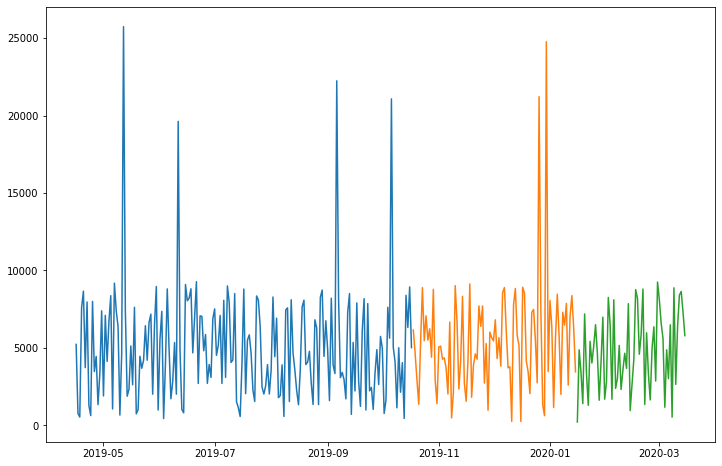

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(validate)
plt.plot(test)
plt.show()

### Simple moving average

In [24]:
# 1 week
sma_short = train.rolling(window=7).mean()
sma_short[:10]

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,NaN
2019-04-17 00:00:00+00:00,NaN
2019-04-18 00:00:00+00:00,NaN
2019-04-19 00:00:00+00:00,NaN
2019-04-20 00:00:00+00:00,NaN
2019-04-21 00:00:00+00:00,NaN
2019-04-22 00:00:00+00:00,4927.508666
2019-04-23 00:00:00+00:00,4365.569200
2019-04-24 00:00:00+00:00,4346.131688


In [25]:
sma_long = train.rolling(window=30).mean()
sma_long[27:33]

,size_mb
timestamp,
2019-05-13 00:00:00+00:00,NaN
2019-05-14 00:00:00+00:00,NaN
2019-05-15 00:00:00+00:00,5311.829708
2019-05-16 00:00:00+00:00,5308.494508
2019-05-17 00:00:00+00:00,5370.210015
2019-05-18 00:00:00+00:00,5606.318019


Text(0, 0.5, 'Size (MB)')

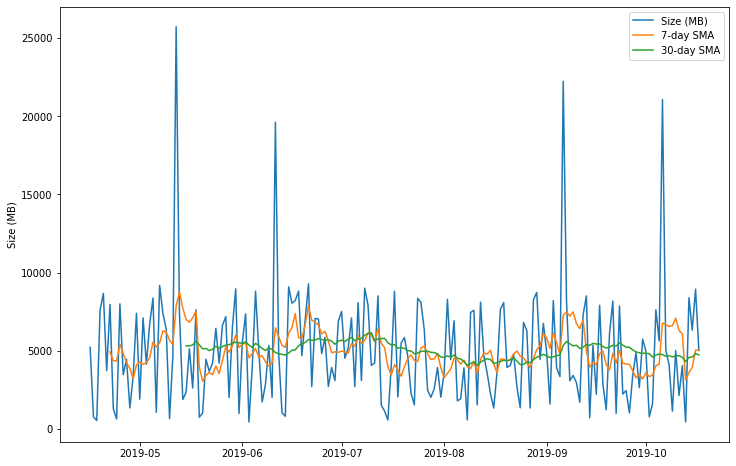

In [26]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train, label='Size (MB)')

ax.plot(train.index, sma_short, label = '7-day SMA')

ax.plot(train.index, sma_long, label = '30-day SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

## Exponential Moving Average
SMA time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units.

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this:

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where:
- M = Number of time periods, span of the window
- $t_{0}$ = Latest value
- $t-1$ = Previous value
- $EMA_{t-1}$ = Exponential moving average of previous day.
- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. So we just need to define the following:
- M = span argument = number of time periods. We will use 1 week, which is $24*2*7 = 336$

In [27]:
ema_short = train.ewm(span=7).mean()
ema_short.head()

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,5226.592266
2019-04-17 00:00:00+00:00,2679.440056
2019-04-18 00:00:00+00:00,1754.037866
2019-04-19 00:00:00+00:00,3891.128802
2019-04-20 00:00:00+00:00,5456.467889


In [28]:
ema_long = train.ewm(span=30).mean()
ema_long.tail()

,size_mb
timestamp,
2019-10-13 00:00:00+00:00,4543.014047
2019-10-14 00:00:00+00:00,4791.527958
2019-10-15 00:00:00+00:00,4890.498588
2019-10-16 00:00:00+00:00,5151.531544
2019-10-17 00:00:00+00:00,5143.098405


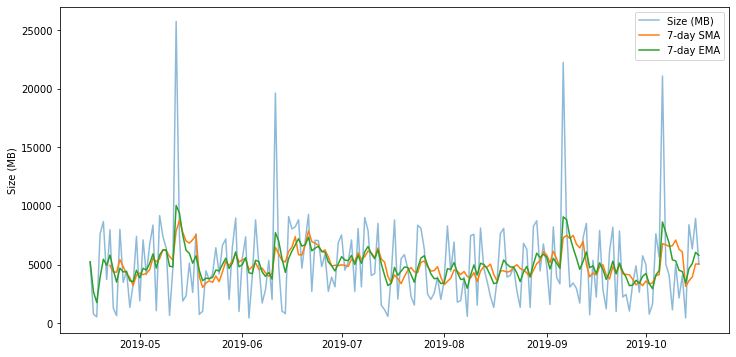

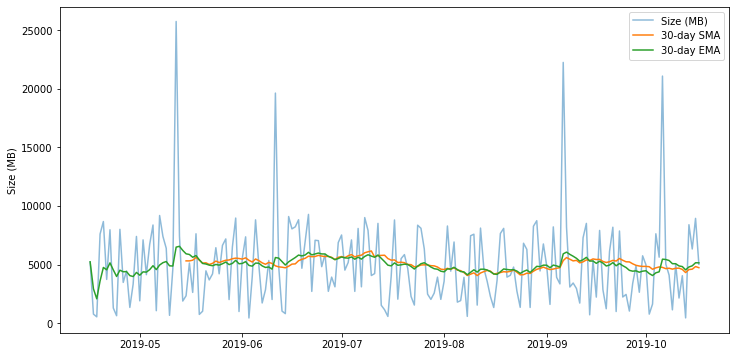

In [29]:
#Comparison of ema and sma

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, sma_short, label = '7-day SMA')
ax.plot(train.index, ema_short, label = '7-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, sma_long, label = '30-day SMA')
ax.plot(train.index, ema_long, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()


## Bollinger Bands and %b
Bollinger Bands
- a volatility indicator and commonly used in stock market trading.
- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.

Midband
- The Exponential Moving Average
- midband = train.ewm(span=30).mean()

Upper & Lower Band
- UB/LB = Midband +/- stdev * K
- stdev = train.ewm(span=30).std()
- K = the number of standard deviations to go up and down from the EMA

%b, Percent Bandwidth
- Shows where the last value sits in relation to the bands
- $\%b = \frac{last-LB}{UB-LB}$
- %b > 1 => point lies above UB
- %b < 0 => point lies below LB
- %b == .5 => point lies on the midband.

Bandwidth
- The width of the bands
- $Bandwidth = \frac{(UB-LB)}{Midband}$

In [30]:
# set the window span
span = 30

# compute midband
midband = train.ewm(span=span).mean()
midband

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,5226.592266
2019-04-17 00:00:00+00:00,2923.542143
2019-04-18 00:00:00+00:00,2075.295212
2019-04-19 00:00:00+00:00,3596.904065
2019-04-20 00:00:00+00:00,4750.390809
...,...
2019-10-13 00:00:00+00:00,4543.014047
2019-10-14 00:00:00+00:00,4791.527958
2019-10-15 00:00:00+00:00,4890.498588


In [31]:
# compute exponential stdev
stdev = train.ewm(span=span).std()
stdev

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,NaN
2019-04-17 00:00:00+00:00,3151.940050
2019-04-18 00:00:00+00:00,2599.778785
2019-04-19 00:00:00+00:00,3533.537646
2019-04-20 00:00:00+00:00,3834.683646
...,...
2019-10-13 00:00:00+00:00,4374.359440
2019-10-14 00:00:00+00:00,4338.995102
2019-10-15 00:00:00+00:00,4214.162042


In [32]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

ub

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,NaN
2019-04-17 00:00:00+00:00,12379.362294
2019-04-18 00:00:00+00:00,9874.631566
2019-04-19 00:00:00+00:00,14197.517004
2019-04-20 00:00:00+00:00,16254.441748
...,...
2019-10-13 00:00:00+00:00,17666.092368
2019-10-14 00:00:00+00:00,17808.513263
2019-10-15 00:00:00+00:00,17532.984714


Text(0, 0.5, 'Size (MB)')

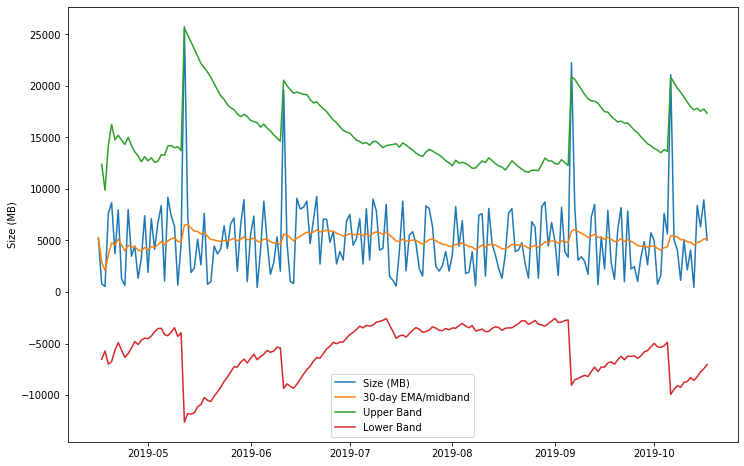

In [33]:
# plot the bands

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(train.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(train.index, 
        ub, 
        label = 'Upper Band')
ax.plot(train.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

Where do you think we will have a %b > 1?

Compute %b

$\%b = \frac{last-LB}{UB-LB}$

In [34]:
train = pd.concat([train, midband, ub, lb], axis=1)
train.columns = ['size_mb', 'midband', 'ub', 'lb']
train.tail()

,size_mb,midband,ub,lb
timestamp,,,,
2019-10-13 00:00:00+00:00,447.434736,4543.014047,17666.092368,-8580.064273
2019-10-14 00:00:00+00:00,8394.959043,4791.527958,17808.513263,-8225.457347
2019-10-15 00:00:00+00:00,6325.565039,4890.498588,17532.984714,-7751.987538
2019-10-16 00:00:00+00:00,8936.490452,5151.531544,17749.914256,-7446.851168
2019-10-17 00:00:00+00:00,5020.818466,5143.098405,17328.698449,-7042.501639


In [35]:
(7626 - (-3926.4))/(13060-(-3926))

0.6801130342635111

In [36]:
train['pct_b'] = (train['size_mb'] - train['lb'])/(train['ub'] - train['lb'])

In [37]:
train[train['pct_b']>1]

,size_mb,midband,ub,lb,pct_b
timestamp,,,,,
2019-05-12 00:00:00+00:00,25735.611832,6483.995643,25586.084249,-12618.092963,1.003914
2019-09-06 00:00:00+00:00,22241.095313,5911.503042,20872.082722,-9049.076639,1.045754
2019-10-06 00:00:00+00:00,21076.200107,5455.861160,20843.906321,-9932.184000,1.007548


## Exercises: Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.



In [42]:
# using function to acquire data
logs, cohorts = get_codeup_data()

# combining DFs using function from local prepare.py file
df = combine_codeup_data(logs, cohorts)

# Using function from prepare file to fill null values
null_filler(df)

# using to_datetime to convert start and end date columns to datetime format
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)

# previewing data
df.head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
datetime,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


In [43]:
# filtering for rows where the datetime value is a date later than the cohort end date
df[df.index > df.end_date]

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id
datetime,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 10:14:47,/,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0
...,...,...,...,...,...,...,...,...
2020-11-02 16:42:02,anomaly-detection/overview,11,28.0,76.185.145.231,Staff,2014-02-04,2014-02-04,2.0
2020-11-02 16:42:02,anomaly-detection/AnomalyDetectionCartoon.jpeg,11,28.0,76.185.145.231,Staff,2014-02-04,2014-02-04,2.0
2020-11-02 16:42:04,anomaly-detection/detecting-with-clustering,11,28.0,76.185.145.231,Staff,2014-02-04,2014-02-04,2.0


In [49]:
print('The data frame above contains all of the users who generated a log entry on a date after the end date of their cohort. In other words, it contains the data of every log entry generated by a user who is accessing the site after their cohort graduated.')

The data frame above contains all of the users who generated a log entry on a date after the end date of their cohort. In other words, it contains the data of every log entry generated by a user who is accessing the site after their cohort graduated.


### Bonus: Can you label students who are viewing both the web dev and data science curriculum? 

In [141]:
# creating column to hold label of whether user has cross access
df['cross_access'] == 'No'

# creating web dev DF 
wd = df[(df.program_id == 1) | ((df.program_id == 2) & (df.name != 'Staff')) | (df.program_id == 4)]

# creating data science DF
ds = df[df.program_id == 3]

In [142]:
# searching web development DF for page_viewed values that contain words from the data science curriculum
wd_cross_access = wd[(wd.page_viewed.str.contains('regression')) | (wd.page_viewed.str.contains('anomaly'))\
   | (wd.page_viewed.str.contains('python')) | (wd.page_viewed.str.contains('classification'))\
   |(wd.page_viewed.str.contains('timeseries'))]

# creating list of user id's for web dev users with cross access
wd_cross_accessers = set(wd_cross_access.user_id.to_list())

# using .where to change cross access status of web dev users to yes if they are in the list
df['cross_access'] = np.where((df.user_id.isin(wd_cross_accessers)), 'Yes', df.cross_access)

In [143]:
# searching data science DF for page_viewed values that contain words from the web development curriculum
ds_cross_access = ds[(ds.page_viewed.str.contains('java')) | (ds.page_viewed.str.contains('spring'))\
   | (ds.page_viewed.str.contains('spring')) | (ds.page_viewed.str.contains('html'))\
   |(ds.page_viewed.str.contains('jquery'))]

# creating list of user id's for DS users with cross access
ds_cross_accessers = set(ds_cross_access.user_id.to_list())

# # using .where to change cross access status of DS users to yes if they are in the list
df['cross_access'] = np.where((df.user_id.isin(ds_cross_accessers )), 'Yes', df.cross_access)

In [145]:
# displaying a few users with cross access
df[df.cross_access == 'Yes'].head()

,page_viewed,user_id,cohort_id,ip,name,start_date,end_date,program_id,cross_access
datetime,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,Yes
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,Yes
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,Yes
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,Yes
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,Yes


### Bonus: Can you label students by the program they are in? 

In [158]:
# creating new column that holds users program, unknown by default
df['program'] = 'Unknown'

# using where to change program to web dev if student's program_id is one that indicates web dev
df['program'] = np.where((df.program_id.isin([1.0,2.0,3.0])), 'Web Dev', df.program)

# using where to change program to data science if student's program_id is one that indicates data science
df['program'] = np.where((df.program_id == 3.0), 'Data Science', df.program)

# displaying counts of each program's user counts
df.program.value_counts()

Web Dev         606597
Data Science     68017
Unknown          44845
Name: program, dtype: int64

### Bonus: Can you label users by student vs. staff? 

### Bonus: What are Zach, Maggie, Faith, and Ryan's ids?